<a href="https://colab.research.google.com/github/strawndri/tmcc-voculary/blob/feature%2Freconhecimento-texto/reconhecimento-texto/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Instalações e importações

## 1.1 Bibliotecas

In [1]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install langdetect

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (25.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [2]:
import pytesseract as pt
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from langdetect import detect

In [3]:
!mkdir tessdata

In [4]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2023-09-05 09:37:02--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-09-05 09:37:02--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2023-09-05 09:37:02--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

## 1.2 Imagens

In [5]:
imagens = {
  'artigo': 'imagens/artigo.png',
  'codigo': 'imagens/codigo.png',
  'imagem_escura': 'imagens/imagem_escura.png',
  'placa': 'imagens/placa.jpg',
  'nota_fiscal': 'imagens/nota_fiscal.png',
  'pagina_1': 'imagens/pagina_1.jpg',
  'pagina_2': 'imagens/pagina_2.jpg',
  'pagina_3': 'imagens/pagina_3.jpg',
  'pagina_4': 'imagens/pagina_4.jpg',
  'pagina_sombra': 'imagens/pagina_sombra_2.png'
}

# 2 Tratamento de imagens

In [6]:
def realcar_detalhes(imagem):
    img_redimensionada = cv2.resize(imagem, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img_suavizada = cv2.GaussianBlur(img_redimensionada, (5, 5), 0)
    img_detalhes = 12 * cv2.subtract(img_redimensionada, img_suavizada)

    return cv2.add(img_redimensionada, img_detalhes)

In [7]:
def ajustar_brilho(imagem, threshold=128, alpha=1.5, beta=50):
    if np.mean(imagem) < threshold:
        return cv2.convertScaleAbs(imagem, alpha=alpha, beta=beta)
    return imagem

In [8]:
def binarizar(imagem):
    _, img_threshold = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if cv2.countNonZero(img_threshold) < (img_threshold.size / 2):
        return 255 - img_threshold
    return img_threshold

In [9]:
def remover_sombra(img):
    cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    media_pixel = np.mean(cinza)
    if 150 < media_pixel < 230:
        bg = cv2.medianBlur(cinza, 21)
        ratio = cinza.astype(np.float32) / bg.astype(np.float32)
        corrigida = cv2.normalize(ratio, None, 0, 255, cv2.NORM_MINMAX)
        corrigida = corrigida.astype(np.uint8)
        return corrigida
    else:
        return cinza

In [10]:
def calcula_angulo(imagem):
    desfocado = cv2.GaussianBlur(imagem, (5, 5), 0)
    bordas = cv2.Canny(desfocado, 50, 150, apertureSize=3)
    linhas = cv2.HoughLines(bordas, 1, np.pi/180, 200)
    if linhas is None:
        return 0
    angulos = [np.degrees(theta) - 90 if np.degrees(theta) - 90 >= 0 else np.degrees(theta) - 90 + 180 for _, theta in linhas[:, 0]]
    return np.median(angulos)

def rotaciona_imagem(imagem, angulo):
    (h, w) = imagem.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    rotacionada = cv2.warpAffine(imagem, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotacionada

def ajustar_orientacao(imagem):

    imagem_rotacionada = imagem
    qualidade_desejada = 50.0
    tentativas = 0
    angulo = calcula_angulo(imagem_rotacionada)
    max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)

    while (max_qualidade < qualidade_desejada):
      imagem_rotacionada = rotaciona_imagem(imagem_rotacionada, angulo)
      max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)
      tentativas += 1
      angulo += 90

      if tentativas == 2:
        break

    return imagem_rotacionada

# 3 Apresentação de imagens

In [11]:
def apresentar_imagens(original, final):

    if len(original.shape) == 2:
        original = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    if len(final.shape) == 2:
        final = cv2.cvtColor(final, cv2.COLOR_GRAY2BGR)
    original = cv2.resize(original, (original.shape[1] // 2, original.shape[0] // 2))
    final = cv2.resize(final, (final.shape[1] // 2, final.shape[0] // 2))
    if original.shape[0] != final.shape[0]:
        altura = original.shape[0]
        largura = int(final.shape[1] * (altura / final.shape[0]))
        final = cv2.resize(final, (largura, altura))
    return np.hstack((original, final))

# 4 Detecção e extração de textos

In [12]:
def avaliar_qualidade_ocr(imagem):
    resultado = pt.image_to_data(imagem, output_type=pt.Output.DICT)
    confiancas = [int(val) for val in resultado['conf'] if str(val).isdigit()]
    if confiancas:
        return sum(confiancas) / len(confiancas)
    return 0

In [13]:
def determinar_psm(imagem):
    pixels_pretos = imagem.size - cv2.countNonZero(imagem)
    proporcao_preto = pixels_pretos / imagem.size

    if proporcao_preto > 0.2:
        return '6'
    else:
        return '1'

In [14]:
def detectar_idioma(imagem):
    codigos = {
        'en': 'eng',
        'pt': 'por'
    }

    try:
        cod_idioma = codigos[detect(pt.image_to_string(imagem))]
    except:
        cod_idioma = 'eng'

    return cod_idioma

In [15]:
def extrair_texto(img_original):

    min_conf = 50

    img_original = cv2.imread(img_original)
    img_realcada = realcar_detalhes(img_original)
    img_com_brilho = ajustar_brilho(img_realcada)
    img_sem_sombra = remover_sombra(img_com_brilho)
    img_binarizada = binarizar(img_sem_sombra)
    img_final = ajustar_orientacao(img_binarizada)

    psm_valor = determinar_psm(img_final)
    cod_idioma = detectar_idioma(img_final)

    resultado = pt.image_to_data(img_final,
                               lang=cod_idioma,
                               config=f'--tessdata-dir tessdata --psm {psm_valor}',
                               output_type=pt.Output.DICT)

    texto_filtrado = [resultado['text'][i] for i in range(len(resultado['conf'])) if int(resultado['conf'][i] >= min_conf)]
    texto = ' '.join(texto_filtrado)

    return apresentar_imagens(img_original, img_final), texto

# 5 Testes de OCR

## 5.1 Segmentação textual

Neste capítulo, busca-se analisar o processo de OCR diante de imagens com diferentes disposições textuais, observando os seguintes aspectos:

* Verticalidade;
* Horizontalidade;
* Organização em formato de bloco;
* Organização em formato de linha.

> **O que é esperado?** *Que o programa seja capaz de reconhecer a natureza da imagem e se adaptar com vistas a detectar de forma inteligente seu texto.*


### 5.1.1 Trecho de artigo

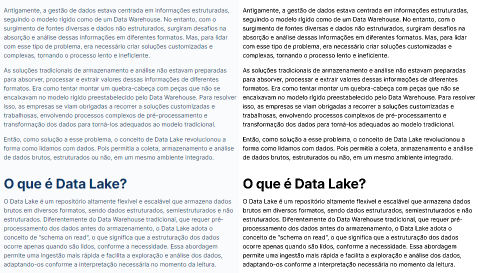

'Antigamente, a gestão de dados estava centrada em informações estruturadas, seguindo o modelo rígido como de um Data Warehouse. No entanto, com o surgimento de fontes diversas e dados não estruturados, surgiram desafios na absorção e análise dessas informações em diferentes formatos. Mas, para lidar com esse tipo de problema, era necessário criar soluções customizadas e complexas, tornando o processo lento e ineficiente. As soluções tradicionais de armazenamento e análise não estavam preparadas para absorver, processar e extrair valores dessas informações de diferentes formatos. Era como tentar montar um quebra-cabeça com peças que não se encaixavam no modelo rígido preestabelecido pelo Data Warehouse. Para resolver i8so, empresas se viam obrigadas a recorrer a soluções customizadas e trabalhosas, envolvendo processos complexos de pré-processamento e transformação dos dados para torná-los adequados ao modelo tradicional. Então, como solução à esse problema, o conceito de Data Lake rev

In [16]:
imagem, texto = extrair_texto(imagens['artigo'])
cv2_imshow(imagem)
texto

### 5.1.2 Trecho de código do Visual Studio Code

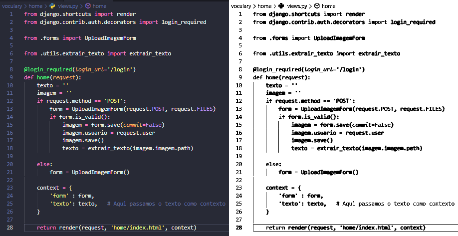

'voculary » home > views.py > @ home 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 26 27 from django.shortcuts import render from django.contrib.auth.decorators import login_required from .forms import from .utils.extrair_texto import extrair_texto @login_required(Login url="/login") def home(reguest): texto = ** imagem = if request.method == form = request.FILES) if form.is_valid(): | = images.usuario = request.user texto = else: form = UploadImagesForm() context = { : form, texto, # Aqui passamos o texto contexto }     return render(request, ‘home/index.html’, comtext) '

In [17]:
imagem, texto = extrair_texto(imagens['codigo'])
cv2_imshow(imagem)
texto

### 5.1.3 Nota fiscal

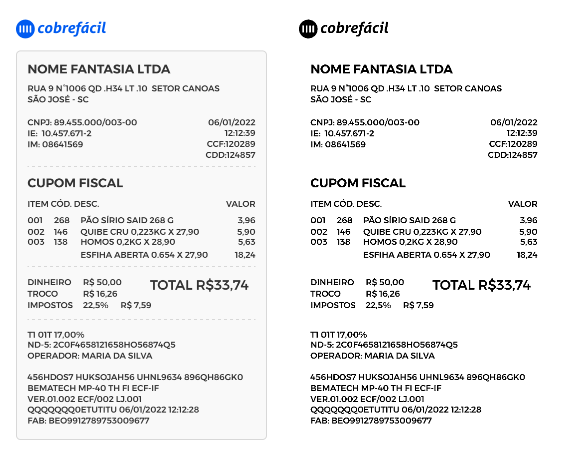

'@ NOME FANTASIA LTDA RUA 9 N"1006 QD .H34 LT .10 SETOR CANOAS SAO JOSE - SC 89.455.000/003-00 06/01/2022 IE: 10.457.671-2 12:12:39 IM: 08641569 CCF:120289 CDD:124857 CUPOM FISCAL ITEM COD. DESC. VALOR 001 268 PAO SIRIOSAID 268G 3,96 002 146 QUIBE CRU 0,223KG X 27,90 5,90 003 138 HOMOS 0,2KG X 28,90 5,63 ESFIHA ABERTA 0.654 X 27,90 18,24 DINHEIRO R$ 50,00 TOTAL R$33,74 TROCO IMPOSTOS 225% R$759 T1 01T 17,00% ND-5: OPERADOR: MARIA DA SILVA 456HDOS7 HUKSOJAH56 UHNL9634 896QHB6GKO BEMATECH MP-40 TH ECF-IF VER.01.002 ECF/002 L1.001 QQQQQQQOETUTITU 06/01/2022 12:12:28 FAB: BEO9912789753009677'

In [18]:
imagem, texto = extrair_texto(imagens['nota_fiscal'])
cv2_imshow(imagem)
texto

## 5.2 Orientação

O objetivo deste capítulo é analisar como a detecção de caracteres se comporta diante de imagens com diferentes orientações.

> **O que é esperado?** *Independente do ângulo de inclinação da imagem, o programa deverá ser capaz de rotacioná-la de modo que seu texto fique reto e esteja organizado de cima para baixo.*

### 5.2.1 Imagem na horizontal

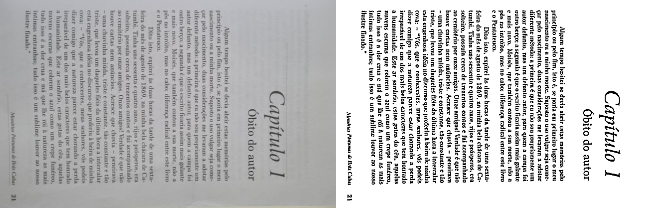

'Capítulo 1 Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto se poria em primeiro lugar o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- çar pelo nascimento, considerações me levaram a adotar diferente método: a primeira é que eu não sou propriamente um autar defunto, um defunto autor, para quem a campa foi berço; a segunda é que o escrito assim mais galante e mais novo, Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este livro € o Pentateuco. Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, rijos e prósperos, era cerca de trezentos contos e fui acompanhado no cemitério por onze amigos. Onze amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia - peneirava - uma chuvinha miúda, triste e constante, tão constante e tão triste, que levou um fiéis 

In [19]:
imagem, texto = extrair_texto(imagens['pagina_1'])
cv2_imshow(imagem)
texto

### 5.2.2 Imagem na horizontal 2

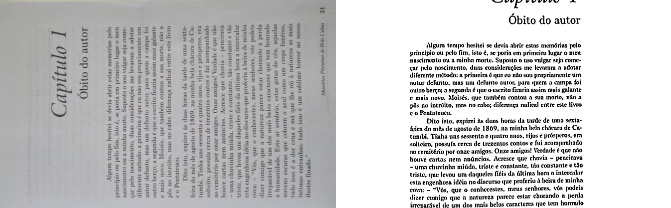

'val/ — Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é&, se poria em primeiro lugar o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- pelo nascimento, duas considerações me levaram adotar diferente método: a primeira é que eu não sou um autar defunto, mas um defunto autor, para quem a campa foi autro berço: à segunda é que o escrito ficaria assim mais galante e mais novo, Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este Pentateuco. Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, rijos e prósperos, era solteiro, cerca de trezentos contos e fui acompanhado no cemitério por onze amigos. Onze amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia — peneirava - uma chuvinha miúda, triste e constante, tão constante e tão triste, que levou um da

In [20]:
imagem, texto = extrair_texto(imagens['pagina_2'])
cv2_imshow(imagem)
texto

### 5.2.3 Imagem levemente inclinada

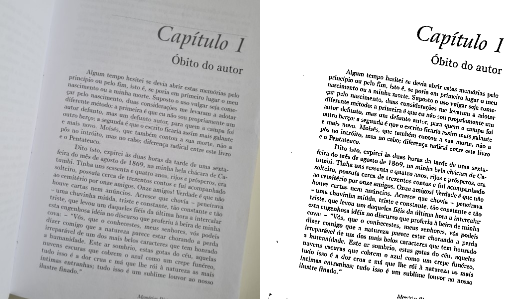

'se devia abrir Menórias Pelo Princípio o é SE e 9 meu ha m Supost, come. Sar Taçõe é : É que não u autor um e foj be ficaria &lante Mais novo. M » qu ambém tontou te, não DÔS no int " mas no c dife, n dical e este livro Piroj Vas horas da º sexta, feira do d de * DA p la de tumbi UNS sessen rijos é S, era solteiro 7 cerca de tr, ntos conto e fu 90 Cernité, ee amigos! Que Núncios, UE Chovia - Pencirava miúda, ecmnstame, tão Stante e i triste, Que um dnqucles fiéis a esta idéia no discurso UE à beira de - “Vós, Que & conhecestes, meus Senhores, vós Podeis dizer irrcpnráVel de um dos mais betos tem honrado a humnnídndv. Este ar Sombrio, gotas do tscurms V cobrem & como UM crepo funõreo. tudo é , Crua e 2 t mntimas cnlmnhas: tudo jsso é um sublime 20 nosso'

In [21]:
imagem, texto = extrair_texto(imagens['pagina_3'])
cv2_imshow(imagem)
texto

### 5.2.4 Imagem de ponta-cabeça

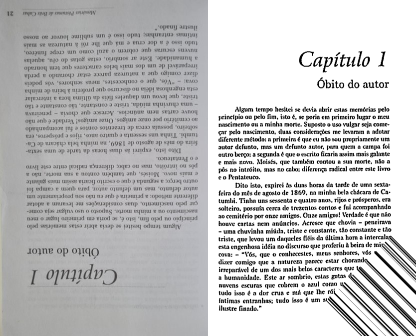

'Capítulo 1 Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é, se poria em primeiro Jugar o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- çar pelo nascimento, duas considerações me levaram à adotar diferente método: a primeira é que eu não sou propriamente um autar defunto, mas um defunto autor, para quem a campa foi outro berço; a segunda é que o escrito ficaria assim mais galante e mais novo, Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este c o Pentateuco. Dito isto, expirei às duas horas da tarde de uma sexta- feira do de agosto de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, e prósperos, era solteiro, possufa cerca de trezentos contos e fui acompanhado a0 cemitério por onze amigos. Onize amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia — peneirava - uma chuvinha miúda, triste e constante, tão constante e tã

In [22]:
imagem, texto = extrair_texto(imagens['pagina_4'])
cv2_imshow(imagem)
texto

## 5.3 Sombra e Imagens escuras

### 5.3.1 Fotografia de página de livro com sombra

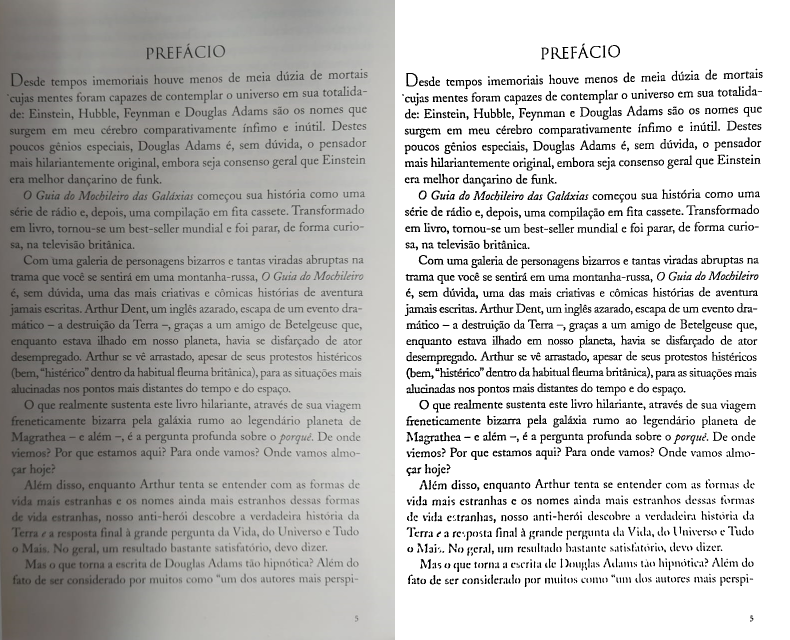

'PREFÁCIO Desde tempos imemoriais houve menos mentes foram capazes de contemplar o univers de: Einstein, Hubble, Feynman e Douglas Adams são os nomes que surgem em meu cérebro comparativamente ínfimo e inútil. Destes poucos gênios especiais, Douglas Adams é, sem dúvida, o pensador mais hilariantemente original, embora seja consenso geral que Einstein era melhor dançarino de funk. O Guia do Mochileiro das Galáxias começou sua história como uma série de rádio e, depois, uma compilação em fita cassete. Transformado em livro, tornou-se um best-seller mundial e foi parar, de forma curio- sa, na televisão britânica. Com uma galeria de personagens bizarros e tantas viradas abruptas na trama que você se sentirá em uma montanha-russa, O Guia do Mochileiro é, sem dúvida, uma das mais criativas e cômicas histórias de aventura Jjamais escritas. Arthur Dent, um inglês azarado, escapa de um evento dra- mático — a destruição da Terra —, graças a um amigo de Betelgeuse que, enquanto estava ilhaudo em 

In [23]:
imagem, texto = extrair_texto(imagens['pagina_sombra'])
cv2_imshow(imagem)
texto

### 5.3.2 Imagem escura

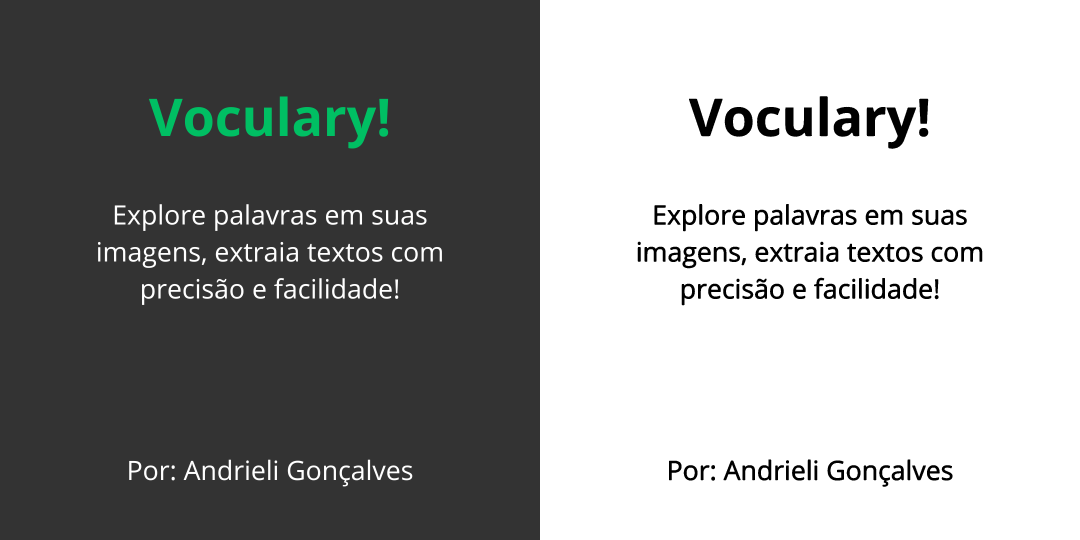

'Voculary! Explore palavras em suas imagens, extraia textos com precisão e facilidade! Por: Andrieli Gonçalves'

In [24]:
imagem, texto = extrair_texto(imagens['imagem_escura'])
cv2_imshow(imagem)
texto